# Vector Error Correction Models (VECM)

## Introduction

In this notebook we will introduce some of the `vecm` module's functionality which helps analyzing a vector error correction model (VECM)
$$\Delta y_t = \alpha \beta^T y_{t-1} + \Gamma_1 \Delta y_{t-1} + \dots + \Gamma_{p-1} \Delta y_{t-p+1} + u_t$$
where $\alpha, \beta \in \mathbb{R}^{K \times r}$ and $\Gamma_i \in \mathbb{R}^{K \times K}$ for $i = 1, \dots, p-1$ are the parameters and $u_t$ is $K$-dimensional white noise. Both $\alpha$ and $\beta$ have rank $r$ - the so called cointegration rank.

Before we demonstrate the module's functionality we take care of the necessary imports.

### General imports

In [8]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import functions as main

import warnings
warnings.filterwarnings('ignore')

### Data import

In [9]:
opencsv = pd.read_csv(r"D:\OneDrive - Instituto Politecnico de Castelo Branco\002_Learning\001_Pos_Graduacao\Ciclo 5 - Projeto Final\ProjetoFinal-PosGraduacaoEngenhariaFinanceira\VECM_data_df_full.csv", sep=",")
opencsv.set_index('Date', inplace=True)
opencsv.index = pd.to_datetime(opencsv.index)
opencsv = opencsv.astype(float)

## Model specification

### Deterministic terms

Let's have a look at the data.

<Axes: xlabel='Date'>

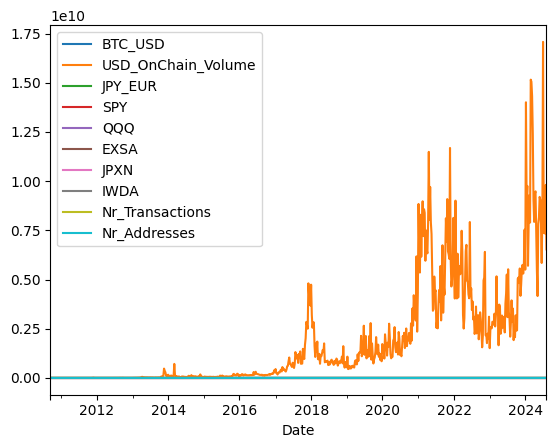

In [21]:
data = opencsv.copy()
data = data.drop(columns=["BTC_PageViews", "Crypto_PageViews"]) # removi porque nao tem a informacao completa para estes anos todos

data.plot.line()

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 726 entries, 2010-09-17 to 2024-08-09
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   BTC_USD             726 non-null    float64
 1   USD_OnChain_Volume  726 non-null    float64
 2   JPY_EUR             726 non-null    float64
 3   SPY                 726 non-null    float64
 4   QQQ                 726 non-null    float64
 5   EXSA                726 non-null    float64
 6   JPXN                726 non-null    float64
 7   IWDA                726 non-null    float64
 8   Nr_Transactions     726 non-null    float64
 9   Nr_Addresses        726 non-null    float64
dtypes: float64(10)
memory usage: 62.4 KB


In [23]:
data.isna().sum()

BTC_USD               0
USD_OnChain_Volume    0
JPY_EUR               0
SPY                   0
QQQ                   0
EXSA                  0
JPXN                  0
IWDA                  0
Nr_Transactions       0
Nr_Addresses          0
dtype: int64

We have the two variables "Dp" (inflation) and "R" (interest) so in our example $K=2$ holds.

In the plot we see that the variable "Dp" has a strong seasonal effect which we will consider by specifying `seasons=4` in several of the following input cells. We also notice that all observations of "R" are greater than zero, so we will include an intercept. It can be shown that a VECM with an intercept can be written as
$$\Delta y_t = \alpha \bar{\beta}^T \begin{pmatrix}y_{t-1}\\1\end{pmatrix} + \Gamma_1 \Delta y_{t-1} + \dots + \Gamma_{p-1} \Delta y_{t-p+1} + u_t$$
with the matrix $\bar{\beta}^T = \begin{pmatrix}\beta^T & -\beta^T\mu\end{pmatrix}$ and $\mu \in \mathbb{R}^K$ being the intercept. So the intercept only appears inside the cointegration relation $\alpha \beta^T y_{t-1}$. In the following cells we will specify this term using `deterministic="ci"` where the _i_ in `"ci"` stands for _inside_.

### Lag order selection

With `select_order()` we can choose the lag order according to various information criteria (AIC, BIC, HQIC, and FPE). To find the best number of lagged differences according to a specific information criterion we can use the `summary()` method of the returned `LagOrderResults` object. We then look for the star (\*) (=minimal value) in the column of interest in the `SimpleTable`. The left cell of the star's row shows the number of lagged differences to choose. So we would choose a lag order of 3 in the following cell if we were interested in the AIC.

In [153]:
# split das df

split = "2019-12-31"

pre_covid_data_df = data.loc[:split]
post_covid_data_df = data.loc[split:]


df_model = pre_covid_data_df.copy()

In [155]:
split = int(0.9*(len(df_model)))

df_train = df_model[:split]
df_test = df_model[split:]

In [156]:
from statsmodels.tsa.vector_ar.vecm import select_order

lag_order = select_order(data=df_train, maxlags=10, deterministic="ci", seasons=0)
lag_order.summary()

,AIC,BIC,FPE,HQIC
0,79.76,80.90*,4.357e+34,80.21*
1,79.57,81.66,3.591e+34,80.39
2,79.52,82.58,3.454e+34,80.73
3,79.52,83.53,3.463e+34,81.11
4,79.45,84.40,3.223e+34,81.40
5,79.43,85.34,3.186e+34,81.76
6,79.42,86.29,3.212e+34,82.13
7,79.38,87.20,3.124e+34,82.47
8,79.32*,88.09,3.010e+34*,82.79
9,79.40,89.13,3.351e+34,83.24


The string representation shows only the rank to choose according to the different information criteria.

In [157]:
print(lag_order)

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 8, BIC -> 0, FPE -> 8, HQIC ->  0>


Of course it is possible to access the lag order direcly via the `LagOrderResults` object as the following cell shows.

In [158]:
lag_order.aic, lag_order.bic, lag_order.fpe, lag_order.hqic

(8, 0, 8, 0)

### Cointegration rank

The function `select_coint_rank` helps us choosing the cointegration rank. The `rank` attribute of the resulting `CointRankResults` object gives us the desired information.

In [159]:
from statsmodels.tsa.vector_ar.vecm import select_coint_rank

rank_test = select_coint_rank(endog=data, det_order=1, k_ar_diff=lag_order.aic)
rank_test.rank

4

To see more details we can use the `summary()` method of `CointRankResults`. Each row of the resulting `SimpleTable` shows one test with the null hypothesis "The cointegration rank is r_0" and $H_1$ "The cointegration rank is greater than r_0 and $\leq$ r_1". The last row contains the information about the cointegration rank to choose. If its test statistic is less than its critical value, use r_0 as the cointegration rank. Otherwise use r_1.

In [160]:
rank_test.summary()

r_0,r_1,test statistic,critical value
0,10,394.2,259.0
1,10,304.6,215.1
2,10,224.8,175.2
3,10,149.4,139.3
4,10,94.07,107.3


Printing a `CointRankResults` object gives a string representation of the `SimpleTable`. (__Question:__ Which of the string representations is more preferable: that of `LagOrderResults` or that of `CointRankResults`?)

In [161]:
print(rank_test)

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0  10          394.2          259.0
  1  10          304.6          215.1
  2  10          224.8          175.2
  3  10          149.4          139.3
  4  10          94.07          107.3
-------------------------------------


## Parameter estimation

To fit a VECM to the data we first build a `VECM` object where we define
  1. the deterministic terms
  2. the lag order, and
  3. the cointegration rank.
We have discussed all three topics above. We have got different suggestions for the lag order depending on the information criterion we used. We will follow the Akaike information criterion (AIC) by using `lag_order.aic`.

Once we have the `VECM` instance, we can call its `fit()` method which returns a `VECMResults` object. This object offers a `summary()` method listing all of the model's parameters with the corresponding standard errors etc.

In [162]:
from statsmodels.tsa.vector_ar.vecm import VECM

#     https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.vecm.VECM.html

model = VECM(endog=df_train, exog=None, deterministic="li", seasons=0, k_ar_diff=lag_order.aic, coint_rank=rank_test.rank)

In [163]:
vecm_res = model.fit()

In [164]:
vecm_res.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
L1.BTC_USD,0.1656,0.055,2.994,0.003,0.057,0.274
L1.USD_OnChain_Volume,-1.494e-07,1.44e-07,-1.041,0.298,-4.31e-07,1.32e-07
L1.JPY_EUR,162.9150,1381.384,0.118,0.906,-2544.548,2870.378
L1.SPY,37.2117,17.773,2.094,0.036,2.377,72.047
L1.QQQ,-44.4608,21.449,-2.073,0.038,-86.500,-2.422
L1.EXSA,-9.5447,87.117,-0.110,0.913,-180.292,161.202
L1.JPXN,-14.2604,30.010,-0.475,0.635,-73.080,44.559
L1.IWDA,71.9981,76.450,0.942,0.346,-77.841,221.837
L1.Nr_Transactions,0.0101,0.003,3.443,0.001,0.004,0.016
L1.Nr_Addresses,-0.0053,0.002,-3.186,0.001,-0.008,-0.002


Of course, all parameters can be accessed via the `VECMResults` instance.

In [165]:
vecm_res.alpha

array([[-9.56015331e-02,  2.03791010e-07, -5.36848769e+02,
        -6.45680388e+00],
       [ 1.89647976e+04, -2.32700784e-01, -7.31478178e+08,
        -4.35921968e+06],
       [-1.09757284e-06, -1.68775694e-12, -1.16396690e+00,
         3.81978493e-04],
       [-6.57216604e-05, -3.59573190e-10,  1.48459659e+00,
        -4.19092746e-02],
       [-1.46991922e-04, -2.04637041e-10, -9.98215801e+00,
        -3.20035956e-02],
       [-7.34510255e-05,  2.29630475e-10, -3.18650127e-01,
         1.27728901e-02],
       [ 7.03184453e-05,  3.41998747e-10, -4.31188831e+00,
         2.60130957e-03],
       [-9.25599290e-05,  2.42428412e-10,  4.34103152e-01,
         9.48162260e-03],
       [ 2.82903666e+00, -2.48224603e-05,  1.20173877e+05,
        -4.17189279e+02],
       [ 5.34763750e+00, -3.95112102e-05,  1.58014948e+05,
        -1.15176461e+03]])

In [166]:
vecm_res.stderr_alpha

array([[2.78588916e-02, 1.02391292e-07, 1.46719024e+03, 3.78356643e+00],
       [1.15394446e+04, 4.24115450e-02, 6.07725559e+08, 1.56719283e+06],
       [3.18906538e-06, 1.17209446e-11, 1.67952325e-01, 4.33112735e-04],
       [2.15008582e-04, 7.90232676e-10, 1.13234402e+01, 2.92007042e-02],
       [1.55094679e-04, 5.70027865e-10, 8.16807081e+00, 2.10636887e-02],
       [3.73053707e-05, 1.37110448e-10, 1.96468965e+00, 5.06650983e-03],
       [6.52799715e-05, 2.39927012e-10, 3.43797373e+00, 8.86579094e-03],
       [4.56142727e-05, 1.67648605e-10, 2.40227848e+00, 6.19495683e-03],
       [1.15581221e+00, 4.24801916e-06, 6.08709214e+04, 1.56972946e+02],
       [1.96484208e+00, 7.22149040e-06, 1.03478529e+05, 2.66848754e+02]])

## Forecasts

Obtaining a forecast for the next $i$ periods is as easy as calling the `predict()` method passing $i$ as the `steps` argument. To get confidence intervals, we also pass the desired confidence level to the argument `alpha`.

In [ ]:
n_forecast = len(df_test)

forecast = vecm_res.predict(steps=n_forecast)

# Convert the forecast to a DataFrame with the same column names as df_train
forecast_df = pd.DataFrame(forecast, index=df_test.index, columns=df_test.columns)
yhat = forecast_df.BTC_USD

In [181]:
def forecast_accuracy(forecast, actual):
    forecast = forecast.values
    actual = actual.values
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))    # MAPE Mean Absolute Percentage Error
    me = np.mean(forecast - actual)                             # ME Mean Error
    mae = np.mean(np.abs(forecast - actual))    # MAE Mean Absolute Error 
    mpe = np.mean((forecast - actual)/actual)   # MPE Mean Percentage Error
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE Root Mean Squared Error
    corr = np.corrcoef(forecast, actual)[0,1]   # corr Correlation
    mins = np.amin(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})


forecast_accuracy(yhat, df_test.BTC_USD)

{'mape': 0.6304639053805948,
 'me': -5118.858220550275,
 'mae': 5118.858220550275,
 'mpe': -0.6304639053805948,
 'rmse': 5696.261872910914,
 'corr': 0.2661773003931605,
 'minmax': 0.6304639053805947}

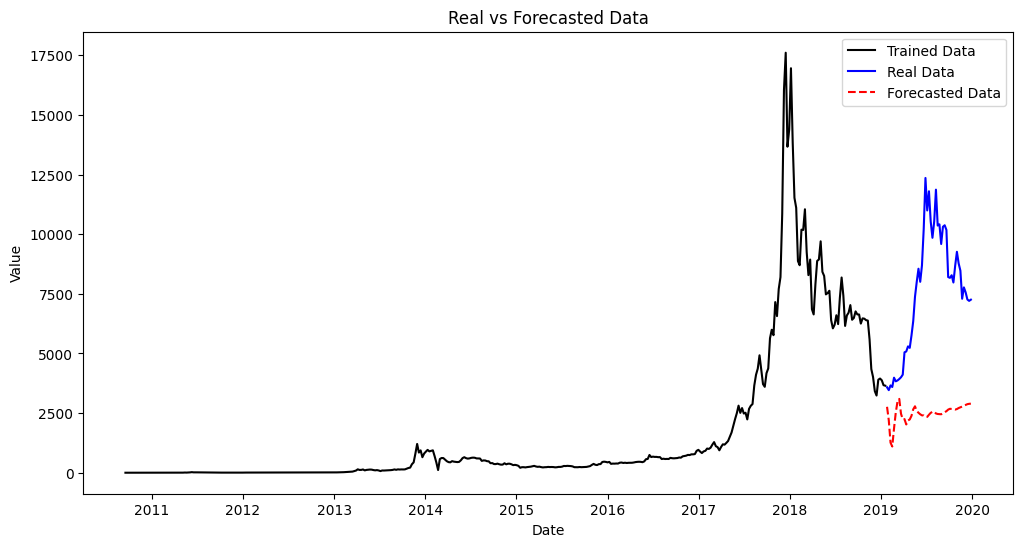

In [182]:
# Plot the real data
plt.figure(figsize=(12, 6))

plt.plot(df_train.index, df_train["BTC_USD"], color='black', label='Trained Data')
plt.plot(df_test.index, df_test["BTC_USD"], color='blue', label='Real Data')

# Plot the forecasted data
plt.plot(yhat.index, yhat, color='red', linestyle='dashed', label='Forecasted Data')

# Add title and labels
plt.title('Real vs Forecasted Data')
plt.xlabel('Date')
plt.ylabel('Value')

plt.legend()
plt.show()

In [170]:
vecm_res.predict(steps=5, alpha=0.05)
for text, vaĺues in zip(("forecast", "lower", "upper"), vecm_res.predict(steps=5, alpha=0.05)):
    print(text+":", vaĺues, sep="\n")

forecast:
[[ 2.76312578e+03  6.66401631e+08  8.31892056e-03  2.41353475e+02
   1.58296622e+02  3.03283030e+01  5.22894516e+01  4.61852819e+01
   2.64213555e+05  4.16850357e+05]
 [ 2.19792777e+03  2.94346483e+08 -2.37935405e-02  2.39705552e+02
   1.56574850e+02  3.03733299e+01  5.35066943e+01  4.62507055e+01
   2.65737980e+05  4.25412964e+05]
 [ 1.26006529e+03  4.21485474e+08  7.66429817e-02  2.36553232e+02
   1.54361641e+02  2.99330508e+01  5.28923215e+01  4.55105217e+01
   2.52964935e+05  4.10381071e+05]
 [ 1.09877493e+03  4.19260726e+08  1.98612588e-02  2.32248121e+02
   1.51199847e+02  2.91298309e+01  5.24705319e+01  4.44104368e+01
   2.69433520e+05  4.51763751e+05]
 [ 1.85618822e+03  1.50801119e+08  5.93559112e-03  2.30006471e+02
   1.49094743e+02  2.86178997e+01  5.16880607e+01  4.37398152e+01
   2.78745484e+05  4.55667069e+05]]
lower:
[[ 2.09420316e+03  3.89326881e+08 -6.82540453e-02  2.36190882e+02
   1.54572629e+02  2.94325601e+01  5.07220077e+01  4.50900331e+01
   2.36461234e+

We can also print the forecasts using the `plot_forecast()` method. In order to have only the point forecasts plotted, we use `plot_conf_int=False`. To restrict the plotted history to the last $i$ observations, we pass this value to the `n_last_obs` argument.

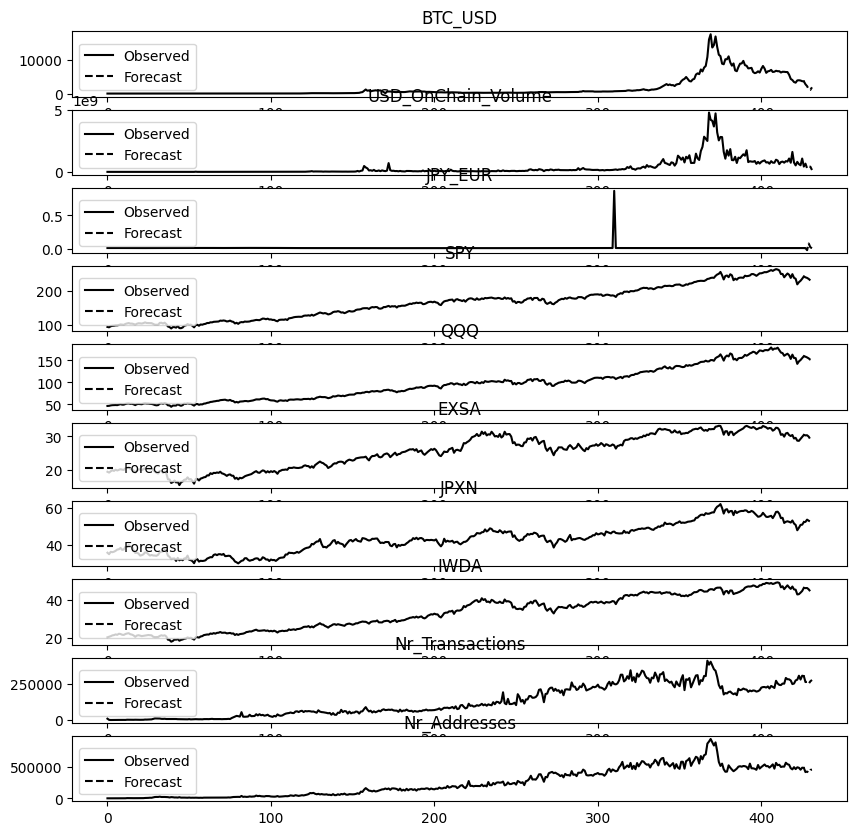

In [183]:
vecm_res.plot_forecast(steps=5, plot_conf_int=False)

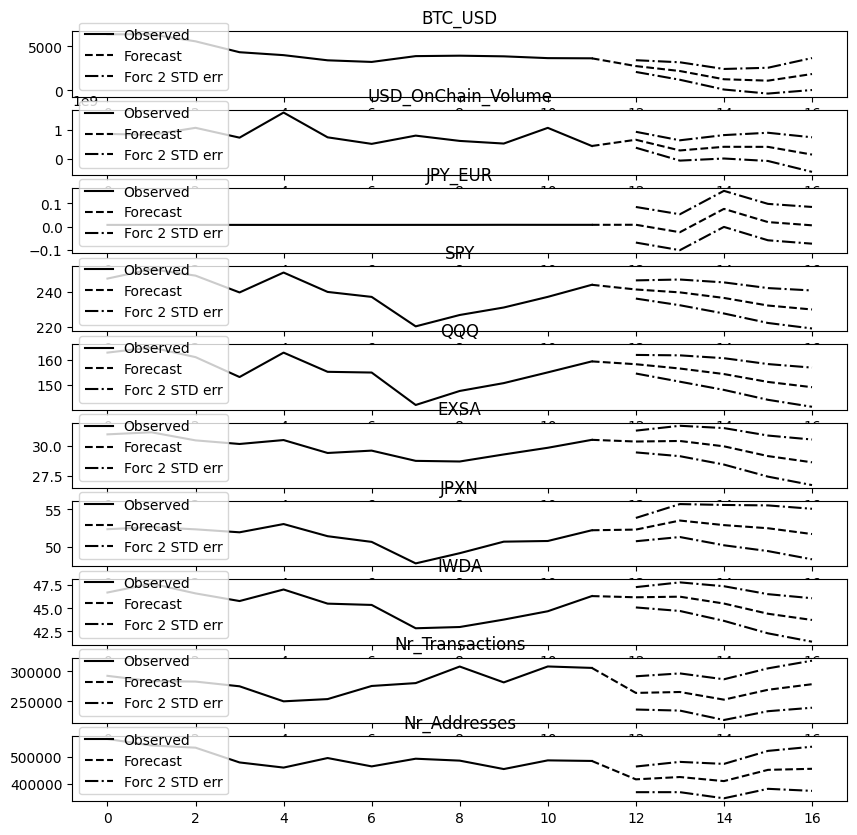

In [172]:
vecm_res.plot_forecast(steps=5, n_last_obs=12)

## Alternative representations

### VAR-representation

Every VECM has a corresponding VAR-model. To get its parameter matrices $A_1, \ldots, A_p$ (where $p$ is the number of lags in levels) we can use the `var_rep()` method.

In [173]:
print(vecm_res.var_rep[0])  # A_1
vecm_res.var_rep

[[ 1.07001018e+00  5.43721878e-08 -3.73933768e+02  3.07548618e+01
  -4.72076509e+01 -1.89416539e+01  2.42569018e+01  5.13202396e+01
   3.96552139e-03 -1.43741435e-03]
 [ 2.61132660e+05  2.39729689e-01 -2.64420419e+08  1.01628622e+07
  -1.19467592e+07  3.18578270e+07  1.47429834e+07 -5.22660027e+07
   2.37037739e+03 -1.05668415e+03]
 [-3.08525844e-06  2.10143128e-12 -4.18583783e-03 -3.06861118e-03
   2.82501176e-03 -6.86252596e-04  3.46575638e-03  4.72859716e-03
   2.66725927e-07  1.54828745e-08]
 [ 1.73534765e-03 -3.01505451e-09 -7.73718892e+00  9.26780271e-01
   5.01861465e-02  4.99748636e-01  1.39446265e-01 -5.72255017e-01
  -6.27572651e-06  7.03214798e-06]
 [ 1.26815643e-03 -2.65036989e-09 -6.82858309e+00  5.32712262e-02
   9.22487153e-01  5.80321679e-01  6.06287902e-02 -6.47010773e-01
  -4.01783295e-06  3.86103313e-06]
 [ 2.01832397e-04 -5.36518553e-10 -1.55892967e+00  1.37483139e-02
  -1.13933344e-02  9.27270554e-01  1.77490021e-02 -2.83888801e-02
   1.94028570e-06  5.84677248e-07

array([[[ 1.07001018e+00,  5.43721878e-08, -3.73933768e+02,
          3.07548618e+01, -4.72076509e+01, -1.89416539e+01,
          2.42569018e+01,  5.13202396e+01,  3.96552139e-03,
         -1.43741435e-03],
        [ 2.61132660e+05,  2.39729689e-01, -2.64420419e+08,
          1.01628622e+07, -1.19467592e+07,  3.18578270e+07,
          1.47429834e+07, -5.22660027e+07,  2.37037739e+03,
         -1.05668415e+03],
        [-3.08525844e-06,  2.10143128e-12, -4.18583783e-03,
         -3.06861118e-03,  2.82501176e-03, -6.86252596e-04,
          3.46575638e-03,  4.72859716e-03,  2.66725927e-07,
          1.54828745e-08],
        [ 1.73534765e-03, -3.01505451e-09, -7.73718892e+00,
          9.26780271e-01,  5.01861465e-02,  4.99748636e-01,
          1.39446265e-01, -5.72255017e-01, -6.27572651e-06,
          7.03214798e-06],
        [ 1.26815643e-03, -2.65036989e-09, -6.82858309e+00,
          5.32712262e-02,  9.22487153e-01,  5.80321679e-01,
          6.06287902e-02, -6.47010773e-01, -4.017832

### MA-representation

To get the first $i+1$ coefficient matrices of the MA-representation, we can call the `ma_rep()` method passing $i$ as the `maxn` argument.

In [174]:
vecm_res.ma_rep(maxn=2)

array([[[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.000000

## Structural analysis

### Granger causality

The `test_granger_causality()` method allows testing for Granger-causality. The returned `CausalityTestResults` object offers a summary of the test via its `summary()` method.

In [175]:
granger_results = vecm_res.test_granger_causality(caused="BTC_USD", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
5.348,1.276,0.000,"(81, 3250)"


When we print a `CausalityTestResults` object we also get all the relevant information.

In [176]:
print(granger_results)

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: ['USD_OnChain_Volume', 'JPY_EUR', 'SPY', 'QQQ', 'EXSA', 'JPXN', 'IWDA', 'Nr_Transactions', 'Nr_Addresses'] do not Granger-cause BTC_USD: reject at 5% significance level. Test statistic: 5.348, critical value: 1.276>, p-value: 0.000>


We can also directly access values of interest.

In [177]:
granger_results.signif, granger_results.pvalue

(0.05, 9.832009753812007e-46)

### Instantaneous causality

Tests for instantaneous causality are executed in a similar fashion using the `test_inst_causality()` method. Again, a `CausalityTestResults` object is returned.

In [178]:
inst_caus = vecm_res.test_inst_causality(causing="BTC_USD")
#inst_caus_r_dp = vecm_res.test_inst_causality(causing="R")
inst_caus.summary()

Test statistic,Critical value,p-value,df
97.45,16.92,0.000,9


We can also compare `HypothesisTestResults` objects (`HypothesisTestResults` is the base class of `CausalityTestResults`). Since instantaneous causality is a symmetric relation (this means that the roles of the caused and the causing variables may be swapped without effect), the following two tests are recognized as equal. Granger causality is not a symmetric relation, so swapping variables leads to `CausalityTestResults` instances which are not equal.

In [179]:
print(inst_caus)

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: BTC_USD does not instantaneously cause [USD_OnChain_Volume, JPY_EUR, SPY, QQQ, EXSA, JPXN, IWDA, Nr_Transactions, Nr_Addresses]: reject at 5% significance level. Test statistic: 97.446, critical value: 16.919>, p-value: 0.000>


In [180]:
granger_results == vecm_res.test_granger_causality(caused="R", signif=0.05)

ValueError: 'R' is not in list

### Impulse-Response-Analysis

To analyze how an impulse in one variable affects the system, we can use the `irf()` method and call the returned object's `plot` method.

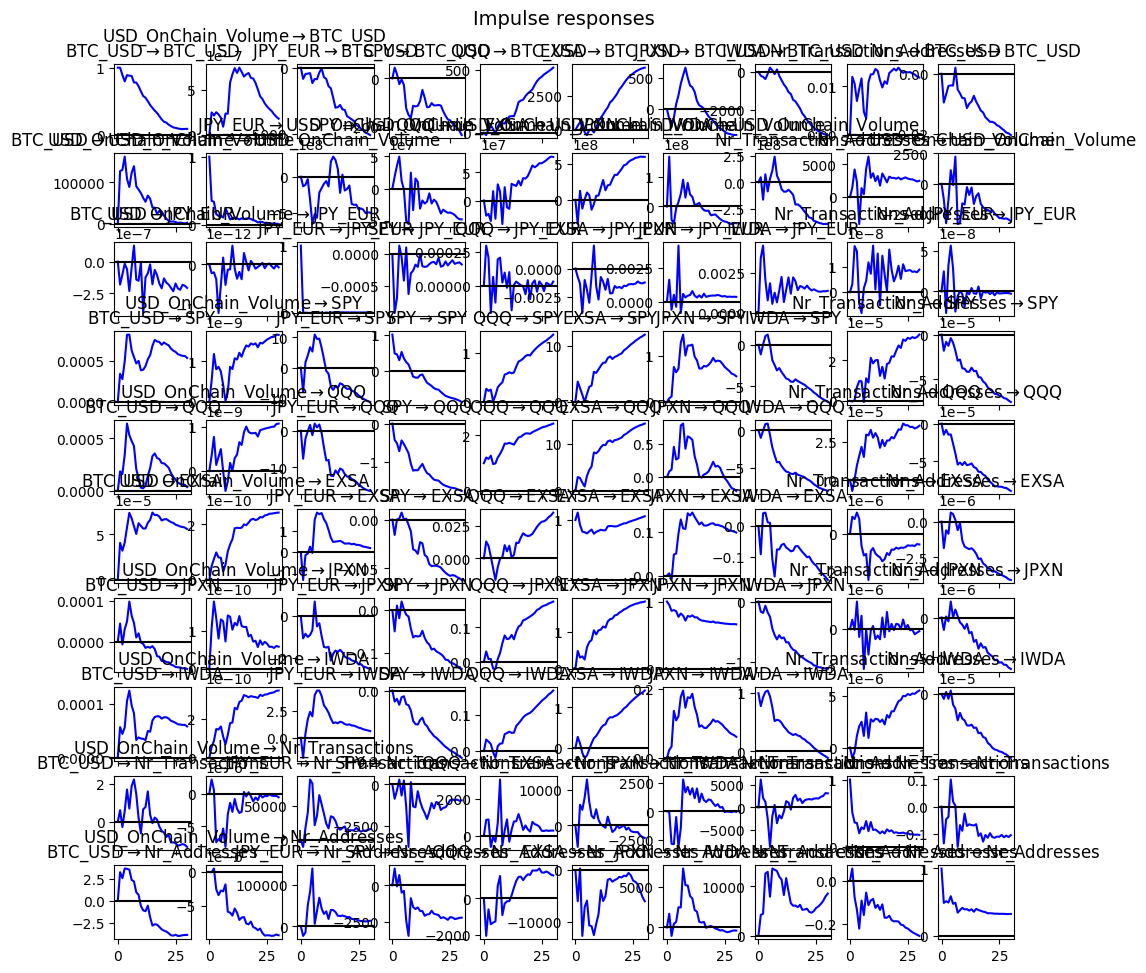

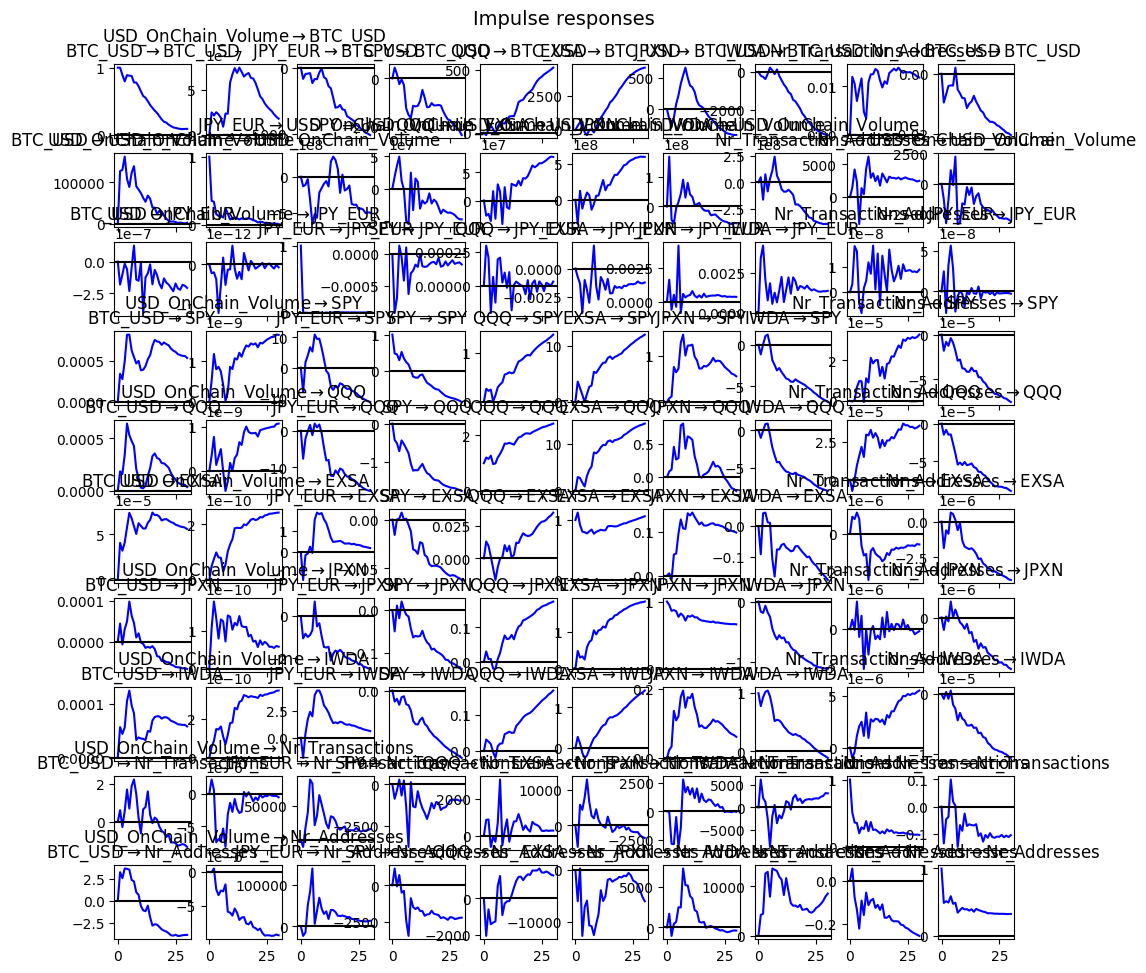

In [ ]:
num_periods = 30
ir = vecm_res.irf(periods=num_periods)
ir.plot(plot_stderr=False)

## Diagnostics

Testing for nonnormality and for residual autocorrelation is possible with the `test_normality()` and `test_whiteness()` methods which return a `NormalityTestResults` and a `WhitenessTestResults` object respectively. Both mentioned classes are subclasses of `HypothesisTestResults` - just as in the case of the causality tests. So we again have the same possibilities as above for inspecting those objects.

### Testing for Nonnormality

In [ ]:
norm_test = vecm_res.test_normality()
norm_test.summary()

Test statistic,Critical value,p-value,df
1.282e+07,31.41,0.000,20


In [ ]:
print(norm_test)

<statsmodels.tsa.vector_ar.hypothesis_test_results.NormalityTestResults object. H_0: data generated by normally-distributed process: reject at 5% significance level. Test statistic: 12818800.998, critical value: 31.410>, p-value: 0.000>


In [ ]:
norm_test.test_statistic, norm_test.crit_value, norm_test.pvalue

(12818800.997962007, 31.410432844230918, 0.0)

### Checking for residual autocorrelation

In [ ]:
white_test = vecm_res.test_whiteness(nlags=12, adjusted=True)
white_test.summary()

Test statistic,Critical value,p-value,df
535.1,394.6,0.000,350


In [ ]:
print(white_test)

<statsmodels.tsa.vector_ar.hypothesis_test_results.WhitenessTestResults object. H_0: residual autocorrelation up to lag 12 is zero: reject at 5% significance level. Test statistic: 535.081, critical value: 394.626>, p-value: 0.000>


In [ ]:
white_test.test_statistic, white_test.crit_value, white_test.pvalue

(535.0809051169421, 394.62576022092185, 6.528605290227563e-10)